In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 检查是否有可用的 GPU
if torch.cuda.is_available():
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU: NVIDIA GeForce RTX 4070 Ti SUPER


Epoch [0/10000], Loss: 0.6404430866241455
Epoch [1000/10000], Loss: 1.4487203770841006e-05
Epoch [2000/10000], Loss: 2.4140758796420414e-06
Epoch [3000/10000], Loss: 4.165463906247169e-06
Epoch [4000/10000], Loss: 9.22319202345534e-07
Epoch [5000/10000], Loss: 7.91021705026651e-07
Epoch [6000/10000], Loss: 4.662493324758543e-07
Epoch [7000/10000], Loss: 1.2412297110131476e-05
Epoch [8000/10000], Loss: 3.8845405470055994e-07
Epoch [9000/10000], Loss: 3.631174649854074e-07
Epoch [10000/10000], Loss: 3.348598056618357e-07


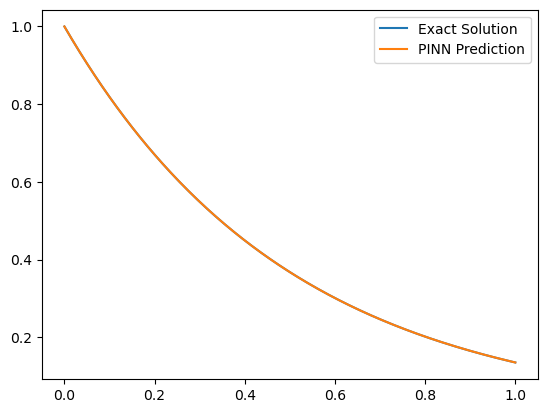

In [3]:
# 定义物理信息神经网络（PINN）
class PINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()

    def forward(self, t):
        x = self.tanh(self.fc1(t))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# 解析解 (analytical solution) 用于验证
def exact_solution(t, k):
    return torch.exp(-k * t)

# 定义损失函数
def pinn_loss(model, t, k):
    # 模型的输出
    y = model(t)

    # 计算y关于t的导数 (dy/dt)
    dydt = torch.autograd.grad(y, t, torch.ones_like(y), create_graph=True)[0]

    # 物理损失：dy/dt + k*y = 0
    physics_loss = torch.mean((dydt + k * y) ** 2)

    # 边界损失：y(0) = 1
    boundary_loss = (y[0] - 1) ** 2

    # 总损失
    total_loss = physics_loss + boundary_loss
    return total_loss

# 训练PINN模型
def train_pinn():
    # 参数设置
    k = 2.0  # 衰减常数
    t_train = torch.linspace(0, 1, 100).view(-1, 1)  # 训练点
    t_train.requires_grad = True  # 计算梯度

    # 初始化模型和优化器
    model = PINN(1, 50, 1)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 训练
    for epoch in range(10001):
        optimizer.zero_grad()  # 梯度清零

        # 计算损失
        loss = pinn_loss(model, t_train, k)
        
        # 反向传播
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            print(f"Epoch [{epoch}/10000], Loss: {loss.item()}")

    return model

# 测试训练结果
def test_pinn(model):
    t_test = torch.linspace(0, 1, 300).view(-1, 1)  # 测试点
    y_pred = model(t_test).detach().numpy()

    # 解析解
    y_exact = exact_solution(t_test, k=2.0).numpy()

    import matplotlib.pyplot as plt
    plt.plot(t_test.numpy(), y_exact, label="Exact Solution")
    plt.plot(t_test.numpy(), y_pred, label="PINN Prediction")
    plt.legend()
    plt.show()

# 主函数
if __name__ == "__main__":
    model = train_pinn()
    test_pinn(model)
